## 자율주행 보조 시스템 만들기

실제 차를 직접 조작하는 자율주행 시스템을 만드는 것이 아닌 자율주행 시스템은 아직 완전하지 않기 떄문에, 위험한 상황에서는 운전자가 직접 운전할 수 있도록 하거나 갑작스럽게 다른 차량이나 사람이 나타나는 상황에서 멈추도록 설계되어야 합니다.     
주변에 다른 차나 사람이 가까이 있는지 확인한 후 멈출 수 있는 자율 주행 보조 시스템을 설계하고 만들어 보겟습니다.  




##  Module import

In [13]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

KITTI 데이터셋을 다운로드

In [14]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

다운로드한 KITTI 데이터셋을 **tfds.show_examples**를 통해 보도록 합시다. 우리가 일반적으로 보는 사진보다 광각으로 촬영되어 다양한 각도의 물체를 확인할 수 있습니다.

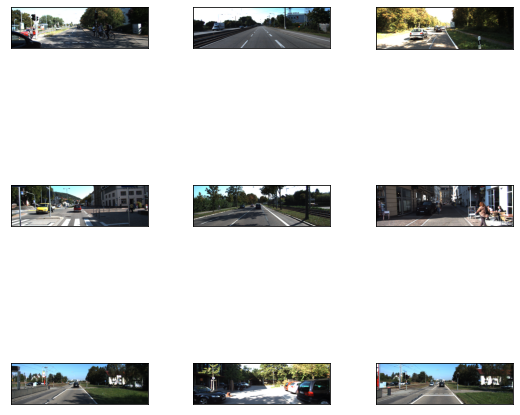

In [15]:
fig = tfds.show_examples(ds_train, ds_info)

데이터 다운로드 시 담아둔 **ds_info**에서는 불러온 데이터셋의 정보를 확인할 수 있습니다. KITTI 데이터셋은 7,481개의 학습 데이터(training data), 711개의 평가용 데이터(test data), 423개의 검증용 데이터(validation data)로 구성되어 있습니다. 라벨에는 **`alpha`**, **`bbox`**, **`dimensions`**, **`location`**, **`occluded`**, **`rotation_y`**, **`truncated`** 등의 정보가 있습니다.



In [16]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/home/ssac27/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
         

###  데이터 확인하기

**`ds_train.take(1)`**을 통해서 데이터셋을 하나씩 뽑아볼 수 있는 **`TakeDataset`**을 얻을 수 있습니다. 이렇게 뽑은 데이터에는 **image** 등의 정보가 포함되어 있습니다.

In [17]:
# train 데이터의 이미지를 확인해 보겠습니다.
TakeDataset = ds_train.take(1)

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(9,), dtype=float32, numpy=
array([ 1.74,  1.25,  1.37, -1.69, -2.87,  1.68, -1.6 , -2.21, -1.92],
      dtype=float32)>, 'bbox': <tf.Tensor: shape=(9, 4), dtype=float32, numpy=
array([[0.18136   , 0.        , 0.45717335, 0.10510467],
       [0.33418667, 0.8492995 , 0.58842665, 0.9986876 ],
       [0.33845332, 0.7364976 , 0.5682667 , 0.8496779 ],
       [0.41021332, 0.30752012, 0.5105867 , 0.35309985],
       [0.44746667, 0.44641706, 0.5588    , 0.52416265],
       [0.42432   , 0.15085346, 0.50629336, 0.18583736],
       [0.47250667, 0.27931562, 0.5313333 , 0.29880837],
       [0.00266667, 0.4983253 , 0.6396    , 0.8265861 ],
       [0.28456   , 0.38590983, 0.49088   , 0.4961433 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(9, 3), dtype=float32, numpy=
array([[1.43, 1.74, 3.63],
       [1.52, 1.55, 3.91],
       [1.62, 1.84, 4.1 ],
       [1.38, 1.73, 3.97],
       [1.74,

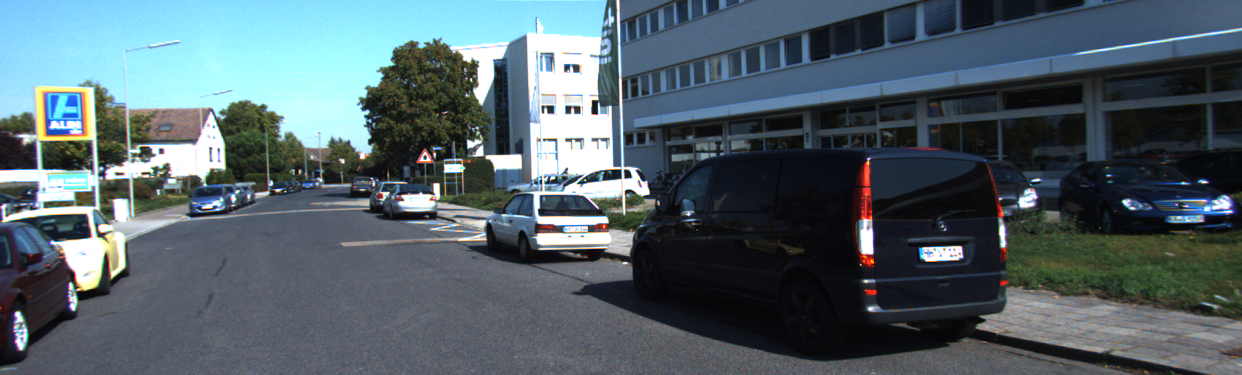

In [20]:
for example in TakeDataset:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

이미지와 라벨을 얻는 방법을 갈게 되었으니 이제 이미지의 바운딩 박스(bounding box, bbox)를 확인해 보겠습니다.

(1242, 375)
width :  1242   height :  375
(9, 4)
x_min :[   0.      1054.83     914.73     381.94     554.45     187.35999
  346.91     618.92     479.30002] , x_max : [ 130.54    1240.37    1055.2999   438.55002  651.01     230.81
  371.12    1026.62     616.21   ] 
y_min : [306.99    249.68    248.08    221.17    207.2     215.87999 197.81
 374.      268.29   ] , y_max : [203.56    154.34001 161.9     183.53    165.45001 185.13998 175.75
 135.15001 190.92   ] 
[  0.   306.99 130.54 203.56]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F5A50D95390>
[1054.83     249.68    1240.37     154.34001]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F5A50D95390>
[ 914.73    248.08   1055.2999  161.9   ]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F5A50D95390>
[381.94    221.17    438.55002 183.53   ]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F5A50D95390>
[554.45    207.2     651.01    165.45001]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F5A50D95390>
[187.3

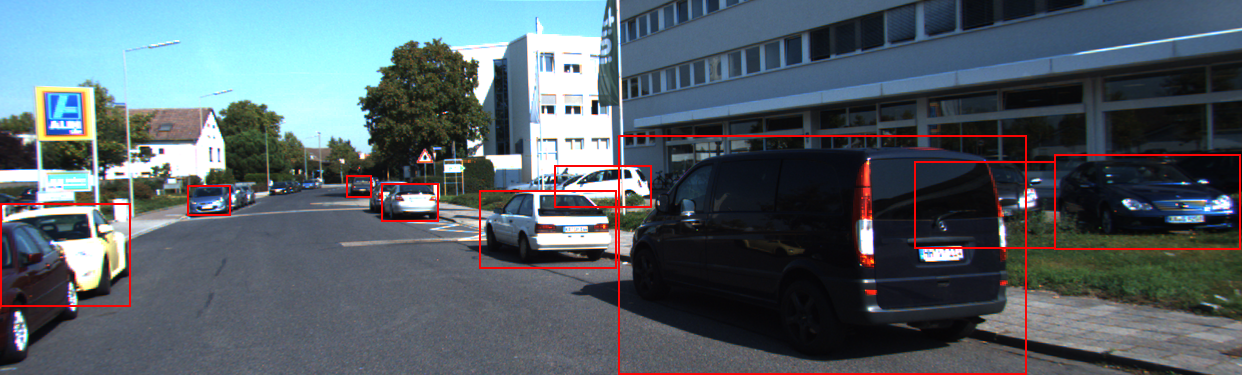

In [21]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    # [[YOUR CODE]]
    print(input_image.size)
    width, height = input_image.size
    print("width : ", width, "  height : ", height)
    print(object_bbox.shape)   #  left, top, right, bottom
    
    # 열을 기준으로 범위 좌표 입력  [width 기준]
    x_min  = object_bbox[:,1] *width  
    x_max = object_bbox[:,3] *width
    # 열을 기준으로 범위 좌표 입력  [height 기준]
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height


    print(f'x_min :{x_min} , x_max : {x_max} ' )
    print(f'y_min : {y_min} , y_max : {y_max} '  )

    # 바운딩 박스 그리기
    # axis=1 [열]을 기준으로 join
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    
    for rect_ in rects:
        print(rect_)
        draw.rectangle(rect_, outline=(250,5,5), width=2)
        print(input_image)
    return input_image
    

visualize_bbox(img, objects['bbox'].numpy())

차 뒤에 사람까지 제대로 bounding box로 그려진것을 확인할 수 있습니다. 

---

## keras-retinanet 
**`tensorflow_dataset`**의 KITTI 데이터셋을 그대로 사용해서 Keras RetinaNet을 학습시키기 위해서는 라이브러리를 수정해야 하지만 좀 더 쉬운 방법인 해당 모델을 훈련할 수 있는 공통된 데이터셋 포맷인 CSV 형태로 모델을 변경해주는 방법을 사용하겠습니다. 

### 클래스 및 바운딩 박스 정보 추출
---
**`tensorflow_dataset`**의 API를 사용해 이미지와 각 이미지에 해당하는 바운딩 박스 라벨의 정보를 얻을 수 있었습니다. 그렇다면 API를 활용하여 데이터를 추출, 이를 포맷팅 하여 CSV 형태로 한 줄씩 저장해 봅시다.  

한 라인에 이미지 파일의 위치, 바운딩 박스 위치, 그리고 클래스 정보를 가지는 CSV 파일을 작성하도록 코드를 작성하고, 이를 사용해 CSV 파일을 생성하겠습니다. 


>**데이터셋 형식**   
>path/to/image.jpg,x1,y1,x2,y2,class_name <br><br>
>**Example**   
>/data/imgs/img_001.jpg,837,346,981,456,cow
>/data/imgs/img_002.jpg,215,312,279,391,cat

In [22]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# KITTI 데이터셋 ds_train을 파싱해서 dataframe으로 변환하는 parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)

    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }

    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        # 코드 구현
        file_name = item['image/file_name'].numpy().decode('utf-8')
        
        img_path = os.path.join(img_dir, file_name)
        
        img = Image.fromarray(item['image'].numpy())  # numpy 데이터를 PIL image로
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        # 열을 기준으로 범위 좌표 입력  [width 기준]
        x_min  = object_bbox[:,1] *width  
        x_max = object_bbox[:,3] *width
        # 열을 기준으로 범위 좌표 입력  [height 기준]
        y_min = height - object_bbox[:,0] * height
        y_max = height - object_bbox[:,2] * height


        #print(f'x_min :{x_min} , x_max : {x_max} ' )
        #print(f'y_min : {y_min} , y_max : {y_max} '  )

        # 바운딩 박스 그리기
        # axis=1 [열]을 기준으로 join
        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)

        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
        

    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [12:30<00:00,  8.46it/s]


테스트 데이터셋에 대해서도 동일하게 **`parse_dataset()`** 을 적용해서 dataframe을 생성해 봅시다.

In [23]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:26<00:00,  8.24it/s]


### 클래스 맵핑
---
데이터셋에서 클래스는 문자열(string)으로 표시되지만, 모델에게 데이터를 알려줄 때에는 숫자를 사용해 클래스를 표시해야 합니다. 이때 모두 어떤 클래스가 있고 각 클래스가 어떤 인덱스(index)에 맵핑(mapping)될지 미리 정하고 저장해 두어야 학습을 한 후 추론(inference)을 할 때에도 숫자 인덱스로 나온 정보를 클래스 이름으로 바꾸어 해석할 수 있습니다.

아래 형식을 참고하여, 자동차와 사람을 구별하기 위한 클래스 맵핑 함수를 만들어 봅시다. 



In [32]:
os.path.join(data_dir, 'classes.txt')

'/home/ssac27/aiffel/object_detection/data/classes.txt'

In [33]:
class_txt_path = os.path.join(data_dir, 'classes.txt')

def save_class_format(path='./classes.txt'):
    # 차와 사람 구분
    class_type = {
        'car' : 0, 
        'person': 1
    }
    with open(path, mode='w', encoding='utf-8') as file:
        for k, v in class_type.items():
            file.write(f'{k}, {v}\n' )
            
save_class_format(class_txt_path)

---

##  keras-retinanet  셋팅
keras 및 Keras RetinaNet 리포지토리를 사용하겠습니다.

학습이 잘 되기 위해서 **batch_size**나 **worker**, **epoch**를 조절해서 학습을 하겠습니다.   


 **batch_size**가 너무 크면 GPU에서 out-of-memory 에러가 날 수 있으니 적절히 조정해주어야 합니다.

In [7]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt

2021-04-22 17:53:22.135461: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-22 17:53:23.126831: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-22 17:53:23.150861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-22 17:53:23.151263: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-22 17:53:23.151285: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-22 17:53:23.152533: I tensorflow/stream_executor/platform

Epoch 1/50
2021-04-22 17:53:34.356289: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-04-22 17:53:35.766670: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2021-04-22 17:53:35.812038: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-04-22 17:53:36.176204: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-04-22 17:53:57.683990: W tensorflow/core/common_runtime/bfc_allocator.cc:246] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021

195/195 [==============================] - ETA: 0s - loss: 1.0707 - regression_loss: 0.8080 - classification_loss: 0.2627
Epoch 00031: saving model to ./snapshots/resnet50_csv_31.h5

Epoch 00031: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
195/195 [==============================] - 59s 301ms/step - loss: 1.0707 - regression_loss: 0.8080 - classification_loss: 0.2627
Epoch 32/50
195/195 [==============================] - ETA: 0s - loss: 0.9797 - regression_loss: 0.7336 - classification_loss: 0.2461
Epoch 00032: saving model to ./snapshots/resnet50_csv_32.h5
195/195 [==============================] - 59s 302ms/step - loss: 0.9797 - regression_loss: 0.7336 - classification_loss: 0.2461
Epoch 33/50
195/195 [==============================] - ETA: 0s - loss: 1.0372 - regression_loss: 0.7839 - classification_loss: 0.2534
Epoch 00033: saving model to ./snapshots/resnet50_csv_33.h5
195/195 [==============================] - 59s 302ms/step - loss: 1.0372 - regression_loss:

195/195 [==============================] - ETA: 0s - loss: 0.9793 - regression_loss: 0.7451 - classification_loss: 0.2342
Epoch 00047: saving model to ./snapshots/resnet50_csv_47.h5
195/195 [==============================] - 59s 302ms/step - loss: 0.9793 - regression_loss: 0.7451 - classification_loss: 0.2342
Epoch 48/50
195/195 [==============================] - ETA: 0s - loss: 0.9489 - regression_loss: 0.7180 - classification_loss: 0.2309
Epoch 00048: saving model to ./snapshots/resnet50_csv_48.h5

Epoch 00048: ReduceLROnPlateau reducing learning rate to 9.999999092680235e-13.
195/195 [==============================] - 59s 303ms/step - loss: 0.9489 - regression_loss: 0.7180 - classification_loss: 0.2309
Epoch 49/50
195/195 [==============================] - ETA: 0s - loss: 1.0270 - regression_loss: 0.7823 - classification_loss: 0.2447
Epoch 00049: saving model to ./snapshots/resnet50_csv_49.h5
195/195 [==============================] - 59s 302ms/step - loss: 1.0270 - regression_loss:

In [8]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_50.h5 snapshots/resnet50_csv_50_infer.h5

2021-04-22 18:44:19.686096: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-22 18:44:21.311800: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-22 18:44:21.342873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-22 18:44:21.345060: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-22 18:44:21.345157: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-22 18:44:21.351230: I tensorflow/stream_executor/platform

---

##  keras-retinanet 시각화
이제 위에서 변환한 모델을 load하고 추론 및 시각화를 해보겠습니다.

아래에 load된 모델을 통해 추론을 하고 시각화를 하는 함수를 작성하겠습니다.  일정 점수 이하는 경우를 제거해야 함을 유의해야 합니다.


In [1]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

boxes :  [[[693.371      168.97876    788.8579     252.21765   ]
  [707.7542     162.70566    827.8409     267.82928   ]
  [  3.4484363  227.34941    156.49702    373.6249    ]
  ...
  [ -0.93173295  -0.93173295  -0.93173295  -0.93173295]
  [ -0.93173295  -0.93173295  -0.93173295  -0.93173295]
  [ -0.93173295  -0.93173295  -0.93173295  -0.93173295]]]
box :  [693.371   168.97876 788.8579  252.21765]
if boxes :  [[[693.371      168.97876    788.8579     252.21765   ]
  [707.7542     162.70566    827.8409     267.82928   ]
  [  3.4484363  227.34941    156.49702    373.6249    ]
  ...
  [ -0.93173295  -0.93173295  -0.93173295  -0.93173295]
  [ -0.93173295  -0.93173295  -0.93173295  -0.93173295]
  [ -0.93173295  -0.93173295  -0.93173295  -0.93173295]]]
len boxes :  1
box :  [707.7542  162.70566 827.8409  267.82928]
if boxes :  [[[693.371      168.97876    788.8579     252.21765   ]
  [707.7542     162.70566    827.8409     267.82928   ]
  [  3.4484363  227.34941    156.49702    373.6249    

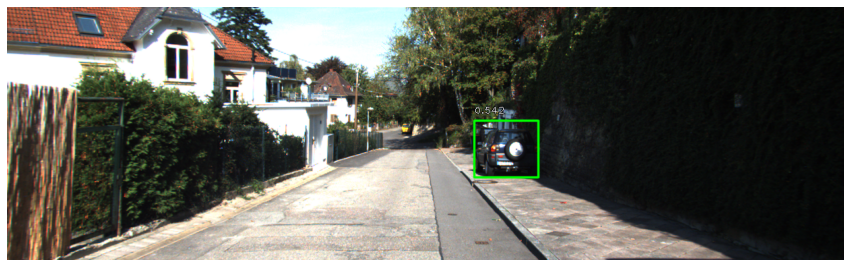

In [85]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_4.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_0.png", visualize=True):
    image = read_image_bgr(img_path)

    # TODO: copy image to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    color_map = {
        0 : (0, 255, 0),  # green
        1 : (255, 0, 0)  #  red
    }

    # TODO: preprocess image for network
    image = preprocess_image(image)   # -1, 1 사이로 전처리
    
        # (img, min_side=800, max_side=1333) , min 보다 작으면 min_side 크기,  max  보다 크면 max_side로 
        # clip()와 동일하다.
    image, scale = resize_image(image)  
    
    # TODO: process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # TODO: correct for image scale
    boxes /= scale
    print("boxes : ", boxes)
    # TODO: display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print("box : ", box)
            print("if boxes : ", boxes)
            print("len boxes : ", len(labels))
            if score < 0.5:   # 일정 점수 이하 제거
                print("score : ", score)
                break
            
            
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])
            
            # img 위에 점수 및 boundding 표시
            caption = "{:.3f}".format(score)   
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()
        

inference_on_image(model, img_path=img_path)

box :  [773.9098 149.312  841.3746 317.0116]
box :  [734.7626  134.67604 860.405   295.82883]
score :  0.13088655


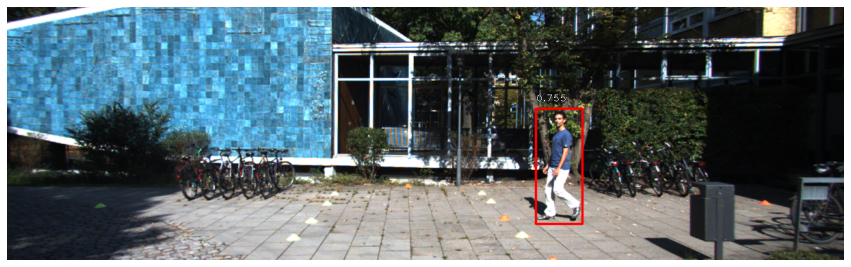

In [20]:
# 차가 봤을떄 정지해야하는 이미지
# -> 사람이 자신의 거리에서 보일떄
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path=img_path)

### 1. 자율주행 시스템 만들기
---
위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

- 입력으로 이미지 경로를 받습니다.
- 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
- 조건은 다음과 같습니다.
  - 사람이 한 명 이상 있는 경우
  - 차량의 크기(width or height)가 300px이상인 경우


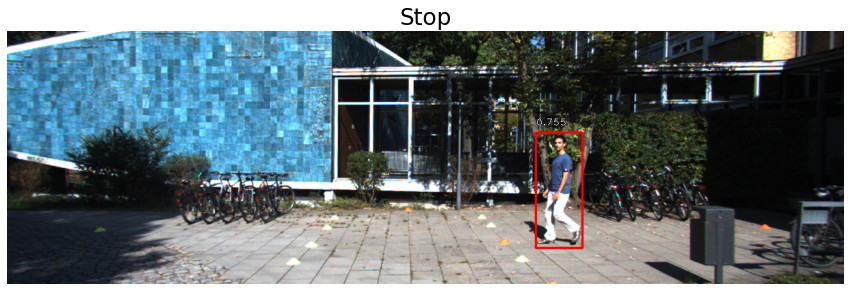

'Stop'

In [86]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'

def self_drive_assist(model, img_path, size_limit=300, visualize=True):
    box_visualize = image_visualize = visualize
    
    # 코드 구현
        # 정지조건에 맞으면 return "Stop"
        # 아닌 경우 return "Go"
    image = read_image_bgr(img_path)
    
    # copy image to draw 
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    color_map = {
        0 : (0,255,20), # Go
        1 : (250, 0, 0 ) # stop
    }
    
    image = preprocess_image(image)  # -1~1의 범위로 전처리    
    image, scale = resize_image(image)    # (img, min_side=800, max_side=1333) , min 보다 작으면 min_side 크기,  max  보다 크면 max_side로 
                                          # clip()와 동일하다.
    
    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    
   # correct for image scale
    boxes /= scale
    
    
    result ="Go" # 입력 이미지에 대한 결과
    
    #  바운딩 박스 좌표(x_min, x_max, y_min, y_max) 

        
    for box, score, label in zip(boxes[0], scores[0], labels[0]) :
        #print(box)
        if score < 0.5:   # 일정 점수 이하 제거
            break
        box = box.astype(int)
                                # 정지 조건
        if not boxes == [] : #  boundingbox가 있는 경우에만 사람과, 차량의 크기 비교
            box_width = box[2] - box[0]  # x_max - m_mia
            box_height = box[3] - box[1]  # y_max-y_min

            if label == 1 : # 사람이 있는 경우
                result = "Stop"
                # 이미지에섭 보이는 차량의 크기[가로, 세로]가 300px 이상인 경우
            elif box_width >=size_limit or box_height >= size_limit :
                result = "Stop"

        if box_visualize:
            # bounding box 표시 여부
            draw_box(draw, box, color=color_map[label])

            # img 위에 점수 및 boundding 표시
            caption = "{:.3f}".format(score)   
            draw_caption(draw, box, caption)

        # 위의 
    if image_visualize:
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.title(result, fontsize=23)
        plt.imshow(draw)
        plt.show()

    print("result : ", result)
    return result


self_drive_assist(model, img_path)

In [46]:
# visualizze 제거했을 때 결과 :
self_drive_assist(model, img_path, visualize=False)

[773.9098 149.312  841.3746 317.0116]
[734.7626  134.67604 860.405   295.82883]


'Stop'

In [43]:
boxes[0][1]

array([193.63362, 134.77963, 346.76218, 234.5571 ], dtype=float32)

### 2. 자율주행 시스템 평가하기
---

아래 **`test_system()`** 를 통해서 위에서 만든 함수를 평가해봅시다.  
10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

In [73]:
import warnings
warnings.filterwarnings('ignore')

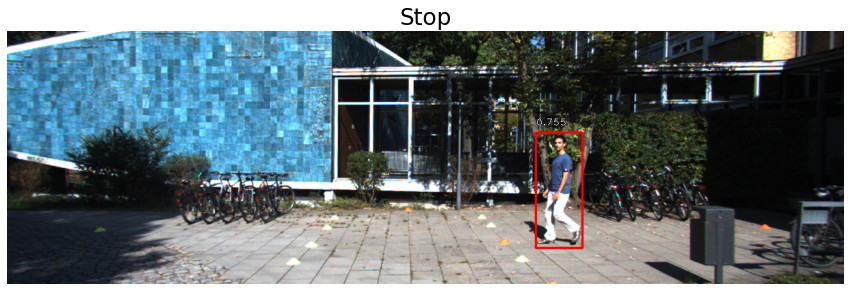

result :  Stop


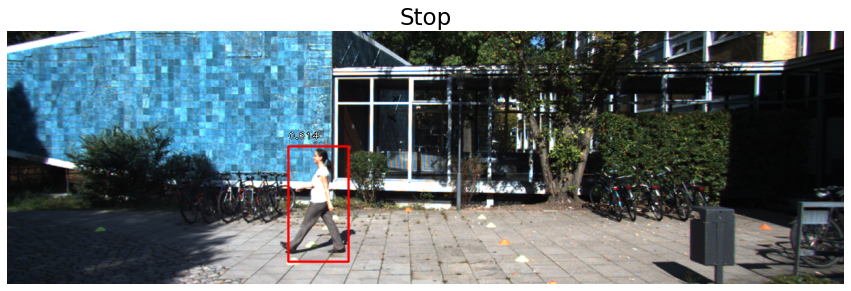

result :  Stop


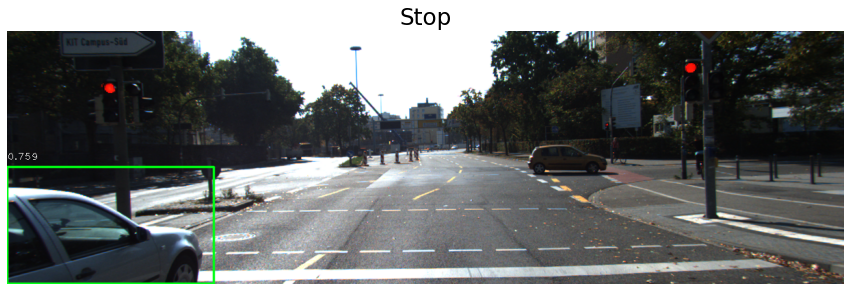

result :  Stop


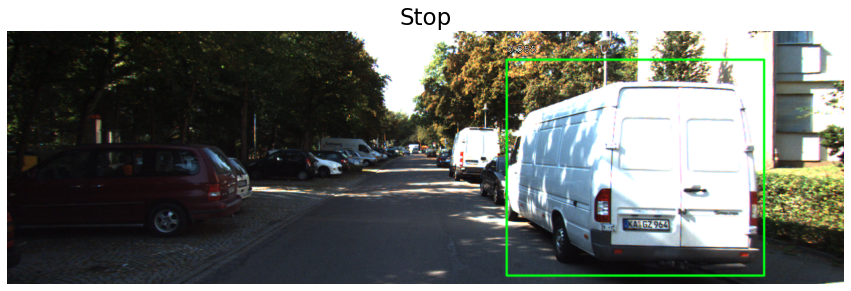

result :  Stop


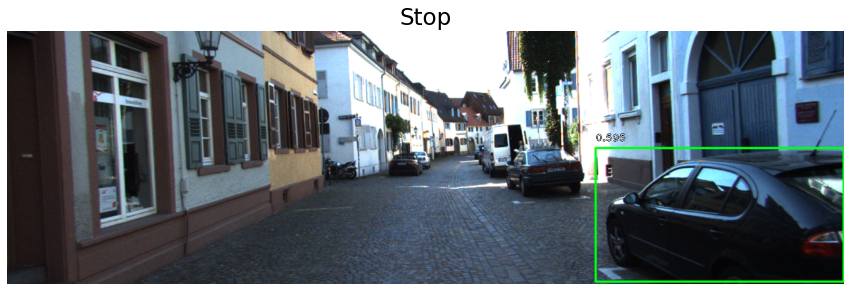

result :  Stop


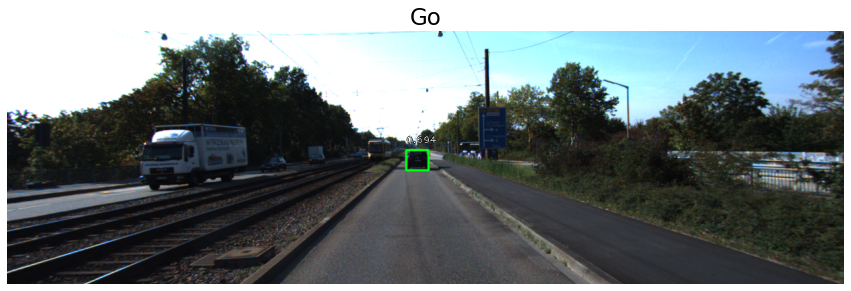

result :  Go


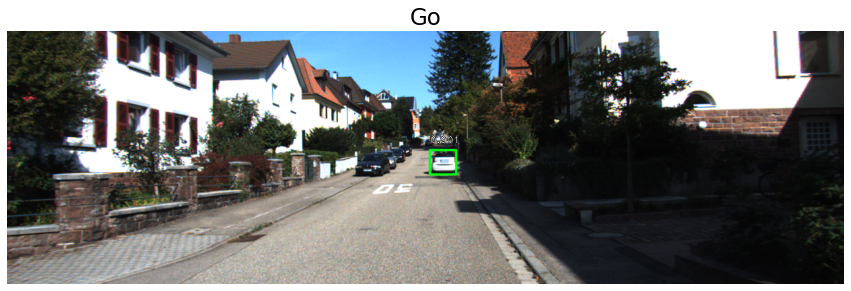

result :  Go


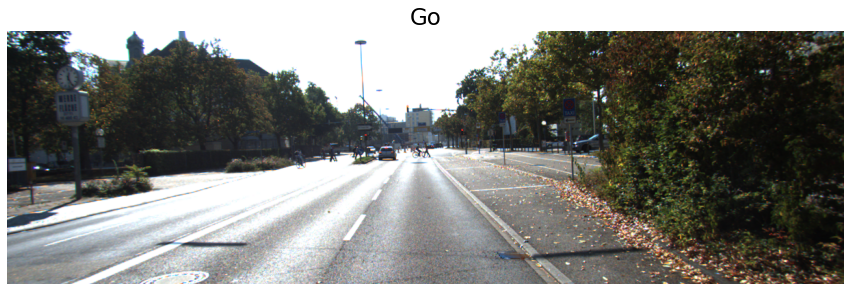

result :  Go


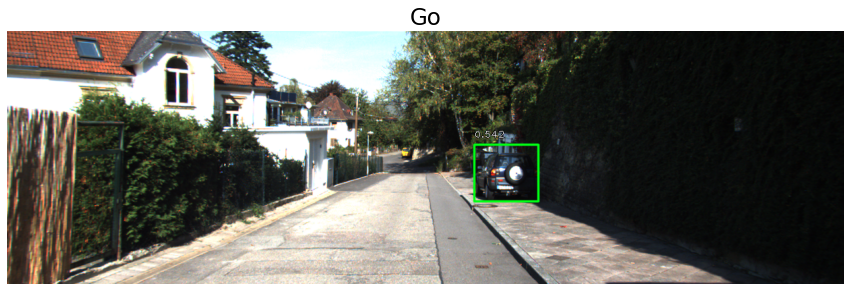

result :  Go


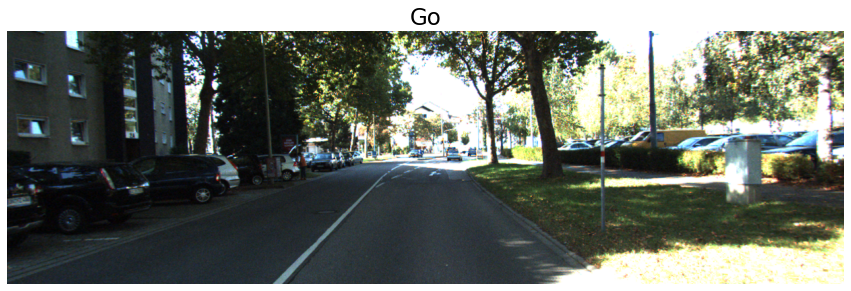

result :  Go
100점입니다.


In [84]:
import os

def test_system(func, visualize=True):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(model,image_path, visualize=visualize)
        #pred = self_drive_assist(model, img_path=image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

In [83]:
# 시각화 하지 않은 상태 
test_system(self_drive_assist, visualize = False)

result :  Stop
result :  Stop
result :  Stop
result :  Stop
result :  Stop
result :  Go
result :  Go
result :  Go
result :  Go
result :  Go
100점입니다.


---
## 회고

- 미니 프로젝트를 시작할때 자율주행에서 필요한 기술이이니 엄청 어렵고 복잡한 기술들만 있을것 같았습니다.  
생각해보니 자율주행차의 직접적인 동작을 제어하는것이 아닌 경우에는 Object를 Detection해서 그에 맞는 판단을 진행하는 것이 자율주행차 였습니다.   

- 지금 한 부분도 간단하고 볼 수 있지만, 실제로 자율주행을 구현할 때 필요하다고 여겨지는 한 부분이라 생각합니다.  
차량이 행인을 제대로 감지하지 못하면 위험하기 때문에 "행인임을 구분할 수 있냐 없냐"와 그렇다면 그렇게 구분한 결과에 대한 답은 "Go"인지 "Stop"인지가 작지만 필요한 기술의 일부분이라고 생각됩니다.  


- KITTI 데이터 셋을 지금은 2D Object Detection 부분만 사용했지만, 나중에 3D object detection 라벨을 가지고 좀 더 정확한 모델을 만들어 보고 싶습니다.   
Retina Net을 사용하면서 Focal Loss와 FPN(Feature Pyramid Network)을 이해하는데 많은 도움이 되었습니다.